# Projet REOP

In [1]:
using SparseArrays

using LightGraphs
using Plots

using JuMP
using GLPK

## Structures

In [2]:
struct Emballage
    e::Int
    l::Float64
    
    Emballage(; e, l) = new(e, l)
end

In [3]:
struct Usine
    u::Int
    v::Int
    coor::Tuple{Float64, Float64}

    cs::Vector{Int}
    s0::Vector{Int}

    b⁺::Matrix{Int}
    r::Matrix{Int}
    
    Usine(; u, v, coor, cs, s0, b⁺, r) = new(u, v, coor, cs, s0, b⁺, r)
end

In [4]:
struct Fournisseur
    f::Int
    v::Int
    coor::Tuple{Float64, Float64}
    
    cs::Vector{Int}
    cexc::Vector{Int}
    s0::Vector{Int}
    
    b⁻::Matrix{Int}
    r::Matrix{Int}
    
    Fournisseur(; f, v, coor, cs, cexc, s0, b⁻, r) = new(f, v, coor, cs, cexc, s0, b⁻, r)
end

In [5]:
Site = Union{Usine, Fournisseur}

Union{Fournisseur, Usine}

In [6]:
struct Graphe
    G::SimpleDiGraph
    d::SparseMatrixCSC{Float64, Int}
    
    Graphe(; G, d) = new(G, d)
end

In [7]:
struct Instance
    J::Int
    U::Int
    F::Int
    E::Int
    
    L::Float64
    γ::Float64
    ccam::Float64
    cstop::Float64
    
    emballages::Vector{Emballage}
    usines::Vector{Usine}
    fournisseurs::Vector{Fournisseur}
    graphe::Graphe
    
    Instance(; J, U, F, E, L, γ, ccam, cstop, emballages, usines, fournisseurs, graphe) = new(
        J, U, F, E, L, γ, ccam, cstop, emballages, usines, fournisseurs, graphe
    )
end

In [8]:
mutable struct RouteStop
    f::Int
    Q::Vector{Int}
    
    RouteStop(; f, Q) = new(f, Q)
end

In [9]:
mutable struct Route
    r::Int
    j::Int
    x::Int
    u::Int
    
    F::Int
    stops::Vector{RouteStop}
    
    Route(; r, j, x, u, F, stops) = new(r, j, x, u, F, stops)
end

In [10]:
mutable struct Solution
    R::Int
    routes::Vector{Route}
    
    Solution(; R, routes) = new(R, routes)
end

## Display utilities

### Printing

In [11]:
function Base.show(io::IO, emballage::Emballage)
    str = "\nEmballage $(emballage.e)"
    str *= "\n   Longueur $(emballage.l)"
    print(io, str)
end

In [12]:
function Base.show(io::IO, usine::Usine)
    str = "\nUsine $(usine.u)"
    str *= "\n   Sommet $(usine.v)"
    str *= "\n   Coordonnées $(usine.coor)"
    str *= "\n   Coûts stock $(usine.cs)"
    str *= "\n   Stock initial $(usine.s0)"
    str *= "\n   Libération journalière $(usine.b⁺)"
    str *= "\n   Stock maximal journalier $(usine.r)"
    print(io, str)
end

In [13]:
function Base.show(io::IO, fournisseur::Fournisseur)
    str = "\nFournisseur $(fournisseur.f)"
    str *= "\n   Sommet $(fournisseur.v)"
    str *= "\n   Coordonnées $(fournisseur.coor)"
    str *= "\n   Coûts stock $(fournisseur.cs)"
    str *= "\n   Coûts expédition carton $(fournisseur.cexc)"
    str *= "\n   Stock initial $(fournisseur.s0)"
    str *= "\n   Consommation journalière $(fournisseur.b⁻)"
    str *= "\n   Stock maximal journalier $(fournisseur.r)"
    print(io, str)
end

In [14]:
function Base.show(io::IO, graphe::Graphe)
    n, m = nv(graphe.G), ne(graphe.G)
    str = "\nGraphe pondéré avec $n sommets et $m arcs"
    str *= "\n   Sommets: " * string(sort(collect(vertices(graphe.G))))
    str *= "\n   Arcs: " * string(sort([(edge.src, edge.dst) for edge in edges(graphe.G)]))
    print(io, str)
end

In [15]:
function Base.show(io::IO, instance::Instance)
    str = "\nInstance"
    str *= "\n   Nombre de jours: $(instance.J)"
    str *= "\n   Nombre d'usines: $(instance.U)"
    str *= "\n   Nombre de fournisseurs: $(instance.F)"
    str *= "\n   Nombre de types d'emballages: $(instance.E)"
    print(io, str)
end

In [16]:
function Base.show(io::IO, route::Route)
    str = "Route $(route.r)"
    str *= "\n   Jour $(route.j)"
    str *= "\n   Nb de camions $(route.x)"
    str *= "\n   Usine de départ $(route.u)"
    str *= "\n   Nb d'arrêts $(route.F)"
    for (stoprank, stop) in enumerate(route.stops)
        str *= "\n   Stop $stoprank"
        str *= "\n      Fournisseur $(stop.f)"
        str *= "\n      Livraison $(stop.Q)"
    end
    print(io, str) 
end

In [17]:
function Base.show(io::IO, solution::Solution)
    str = "Solution"
    str *= "\n   Nb de routes: $(solution.R)"
    print(io, str)
end

### Plotting

In [18]:
function plot_sites(instance::Instance)
    G = instance.graphe.G
    d = instance.graphe.d
    pl = scatter(
        [usine.coor[1] for usine in instance.usines],
        [usine.coor[2] for usine in instance.usines],
        marker = (30, 0.5, "red"),
        label = "usines"
    )
    annotate!(
        pl,
        [
            (usine.coor[1], usine.coor[2], text(string(usine.u), :darkred, :center))
            for usine in instance.usines
        ]
    )
    scatter!(
        pl, 
        [fournisseur.coor[1] for fournisseur in instance.fournisseurs],
        [fournisseur.coor[2] for fournisseur in instance.fournisseurs],
        marker = (30, 0.5, "blue"),
        label = "fournisseurs"
    )
    annotate!(
        pl,
        [
            (fournisseur.coor[1], fournisseur.coor[2], text(string(fournisseur.f), :darkblue, :center))
            for fournisseur in instance.fournisseurs
        ]
    )
    plot!(pl, grid=false, xlabel="longitude", ylabel="latitude", title="Sites de l'instance")
    return pl
end

plot_sites (generic function with 1 method)

## Data parsing

In [19]:
data_petite = open(joinpath("..", "sujet", "petite.csv")) do file
    readlines(file)
end

33-element Array{String,1}:
 "J 3 U 2 F 3 E 2 L 13000 Gamma 1 CCam 100 CStop 10"
 "e 0 l 300"
 "e 1 l 200"
 "u 0 v 0 coor 48.8666672 2.3514623 ce e 0 cr 2 b 4 e 1 cr 4 b 5 lib j 0 e 0 b 5 r 5 e 1 b 0 r 5 j 1 e 0 b 10 r 5 e 1 b 5 r 5 j 2 e 0 b 0 r 5 e 1 b 5 r 5"
 "u 1 v 1 coor 43.6044622 1.4442469 ce e 0 cr 2 b 3 e 1 cr 4 b 6 lib j 0 e 0 b 2 r 5 e 1 b 3 r 5 j 1 e 0 b 2 r 5 e 1 b 3 r 5 j 2 e 0 b 2 r 5 e 1 b 3 r 5"
 "f 0 v 2 coor 48.8666672 2.3514623 ce e 0 cr 2 cexc 55 b 2 e 1 cr 4 cexc 30 b 6 dem j 0 e 0 b 2 r 5 e 1 b 1 r 5 j 1 e 0 b 2 r 5 e 1 b 1 r 5 j 2 e 0 b 2 r 5 e 1 b 1 r 5"
 "f 1 v 3 coor 45.7578137 4.8320114 ce e 0 cr 2 cexc 45 b 4 e 1 cr 4 cexc 40 b 5 dem j 0 e 0 b 0 r 5 e 1 b 2 r 4 j 1 e 0 b 0 r 6 e 1 b 2 r 4 j 2 e 0 b 0 r 3 e 1 b 2 r 4"
 "f 2 v 4 coor 45.7578137 4.8320114 ce e 0 cr 2 cexc 35 b 7 e 1 cr 4 cexc 50 b 4 dem j 0 e 0 b 3 r 5 e 1 b 0 r 5 j 1 e 0 b 3 r 5 e 1 b 0 r 5 j 2 e 0 b 3 r 5 e 1 b 0 r 5"
 "a 0 0 d 0"
 "a 0 1 d 10"
 "a 0 2 d 0"
 "a 0 3 d 8"
 "a 0 4 d 8"
 ⋮
 "a 2

In [20]:
sol_petite = open(joinpath("..", "sujet", "petite.txt")) do file
    readlines(file)
end

4-element Array{String,1}:
 "R 3"
 "r 0 j 0 x 1 u 0 F 1 f 0 e 0 q 0 e 1 q 2"
 "r 1 j 1 x 1 u 0 F 3 f 0 e 0 q 1 e 1 q 1 f 1 e 0 q 1 e 1 q 1 f 2 e 0 q 1 e 1 q 1"
 "r 2 j 1 x 2 u 1 F 2 f 1 e 0 q 3 e 1 q 1 f 2 e 0 q 0 e 1 q 1"

### Dimensions

In [21]:
function lire_dimensions(row::String)::NamedTuple
    row_split = split(row, r"\s+")
    return (
        J = parse(Int, row_split[2]),
        U = parse(Int, row_split[4]),
        F = parse(Int, row_split[6]),
        E = parse(Int, row_split[8]),
        L = parse(Float64, row_split[10]),
        γ = parse(Float64, row_split[12]),
        ccam = parse(Float64, row_split[14]),
        cstop = parse(Float64, row_split[16]),
    )
end

lire_dimensions (generic function with 1 method)

In [22]:
dims_petite = lire_dimensions(data_petite[1])

(J = 3, U = 2, F = 3, E = 2, L = 13000.0, γ = 1.0, ccam = 100.0, cstop = 10.0)

### Emballages

In [23]:
function lire_emballage(row::String, dims::NamedTuple)::Emballage
    row_split = split(row, r"\s+")
    e = parse(Int, row_split[2]) + 1
    l = parse(Float64, row_split[4])
    return Emballage(e=e, l=l)
end

lire_emballage (generic function with 1 method)

In [24]:
emballages_petite = [lire_emballage(data_petite[1+e], dims_petite) for e = 1:dims_petite.E]

2-element Array{Emballage,1}:
 
Emballage 1
   Longueur 300.0
 
Emballage 2
   Longueur 200.0

### Usines

In [25]:
function lire_usine(row::String, dims::NamedTuple)::Usine
    row_split = split(row, r"\s+")
    u = parse(Int, row_split[2]) + 1
    v = parse(Int, row_split[4]) + 1
    coor = (parse(Float64, row_split[6]), parse(Float64, row_split[7]))
    k = 8
    
    cs = Vector{Int}(undef, dims.E)
    s0 = Vector{Int}(undef, dims.E)
    
    k += 1
    for e = 1:dims.E 
        cs[e] = parse(Float64, row_split[k+3])
        s0[e] = parse(Int, row_split[k+5])
        k += 6
    end
    
    b⁺ = Matrix{Int}(undef, dims.E, dims.J)
    r = Matrix{Int}(undef, dims.E, dims.J)
    
    k += 1
    for j = 1:dims.J
        k += 2
        for e = 1:dims.E
            b⁺[e, j] = parse(Int, row_split[k+3])
            r[e, j] = parse(Int, row_split[k+5])
            k += 6
        end
    end
    
    return Usine(u=u, v=v, coor=coor, cs=cs, s0=s0, b⁺=b⁺, r=r)
end

lire_usine (generic function with 1 method)

In [26]:
usines_petite = [lire_usine(data_petite[1+dims_petite.E+u], dims_petite) for u = 1:dims_petite.U]

2-element Array{Usine,1}:
 
Usine 1
   Sommet 1
   Coordonnées (48.8666672, 2.3514623)
   Coûts stock [2, 4]
   Stock initial [4, 5]
   Libération journalière [5 10 0; 0 5 5]
   Stock maximal journalier [5 5 5; 5 5 5]
 
Usine 2
   Sommet 2
   Coordonnées (43.6044622, 1.4442469)
   Coûts stock [2, 4]
   Stock initial [3, 6]
   Libération journalière [2 2 2; 3 3 3]
   Stock maximal journalier [5 5 5; 5 5 5]

### Fournisseurs

In [27]:
function lire_fournisseur(row::String, dims::NamedTuple)::Fournisseur
    row_split = split(row, r"\s+")
    f = parse(Int, row_split[2]) + 1
    v = parse(Int, row_split[4]) + 1
    coor = (parse(Float64, row_split[6]), parse(Float64, row_split[7]))
    k = 8
    
    cs = Vector{Int}(undef, dims.E)
    cexc = Vector{Int}(undef, dims.E)
    s0 = Vector{Int}(undef, dims.E)
    
    k += 1
    for e = 1:dims.E
        cs[e] = parse(Float64, row_split[k+3])
        cexc[e] = parse(Float64, row_split[k+5])
        s0[e] = parse(Float64, row_split[k+7])
        k += 8
    end
    
    b⁻ = Matrix{Int}(undef, dims.E, dims.J)
    r = Matrix{Int}(undef, dims.E, dims.J)
    
    k += 1
    for j = 1:dims.J
        k += 2
        for e = 1:dims.E
            b⁻[e, j] = parse(Int, row_split[k+3])
            r[e, j] = parse(Int, row_split[k+5])
            k += 6
        end
    end
    
    return Fournisseur(f=f, v=v, coor=coor, cs=cs, cexc=cexc, s0=s0, b⁻=b⁻, r=r)
end

lire_fournisseur (generic function with 1 method)

In [28]:
fournisseurs_petite = [lire_fournisseur(data_petite[1+dims_petite.E+dims_petite.U+f], dims_petite) for f = 1:dims_petite.F]

3-element Array{Fournisseur,1}:
 
Fournisseur 1
   Sommet 3
   Coordonnées (48.8666672, 2.3514623)
   Coûts stock [2, 4]
   Coûts expédition carton [55, 30]
   Stock initial [2, 6]
   Consommation journalière [2 2 2; 1 1 1]
   Stock maximal journalier [5 5 5; 5 5 5]
 
Fournisseur 2
   Sommet 4
   Coordonnées (45.7578137, 4.8320114)
   Coûts stock [2, 4]
   Coûts expédition carton [45, 40]
   Stock initial [4, 5]
   Consommation journalière [0 0 0; 2 2 2]
   Stock maximal journalier [5 6 3; 4 4 4]
 
Fournisseur 3
   Sommet 5
   Coordonnées (45.7578137, 4.8320114)
   Coûts stock [2, 4]
   Coûts expédition carton [35, 50]
   Stock initial [7, 4]
   Consommation journalière [3 3 3; 0 0 0]
   Stock maximal journalier [5 5 5; 5 5 5]

### Graphe

In [29]:
function lire_arc(row::String)::NamedTuple
    row_split = split(row, r"\s+")
    v1 = parse(Int, row_split[2]) + 1
    v2 = parse(Int, row_split[3]) + 1
    d = parse(Float64, row_split[5])
    return (v1=v1, v2=v2, d=d)
end

lire_arc (generic function with 1 method)

In [30]:
function lire_graphe(rows::Vector{String}, dims::NamedTuple)::Graphe
    G = SimpleDiGraph(dims.U + dims.F)
    d = spzeros(dims.U + dims.F, dims.U + dims.F)
    for row in rows
        a = lire_arc(row)
        if a.d > eps()
            add_edge!(G, a.v1, a.v2)
            d[a.v1, a.v2] = a.d
        end
    end
    return Graphe(G=G, d=d)
end

lire_graphe (generic function with 1 method)

In [31]:
graphe_petite = lire_graphe(data_petite[1+dims_petite.E+dims_petite.U+dims_petite.F+1:end], dims_petite)


Graphe pondéré avec 5 sommets et 16 arcs
   Sommets: [1, 2, 3, 4, 5]
   Arcs: [(1, 2), (1, 4), (1, 5), (2, 1), (2, 3), (2, 4), (2, 5), (3, 2), (3, 4), (3, 5), (4, 1), (4, 2), (4, 3), (5, 1), (5, 2), (5, 3)]

### Instance

In [32]:
function lire_instance(path::String)::Instance
    data = open(path) do file
        readlines(file)
    end

    dims = lire_dimensions(data[1])
    emballages = [
        lire_emballage(data[1+e], dims) for e = 1:dims.E
    ]
    usines = [
        lire_usine(data[1+dims.E+u], dims) for u = 1:dims.U
    ]
    fournisseurs = [
        lire_fournisseur(data[1+dims.E+dims.U+f], dims) for f = 1:dims.F
    ]
    graphe = lire_graphe(data[1+dims.E+dims.U+dims.F+1:end], dims)
    
    return Instance(
        J = dims.J,
        U = dims.U,
        F = dims.F,
        E = dims.E,
        
        L = dims.L,
        γ = dims.γ,
        ccam = dims.ccam,
        cstop = dims.cstop,
        
        emballages = emballages,
        usines = usines,
        fournisseurs = fournisseurs,
        graphe = graphe
    )
end

lire_instance (generic function with 1 method)

In [33]:
instance_petite = lire_instance(joinpath("..", "sujet", "petite.csv"))


Instance
   Nombre de jours: 3
   Nombre d'usines: 2
   Nombre de fournisseurs: 3
   Nombre de types d'emballages: 2

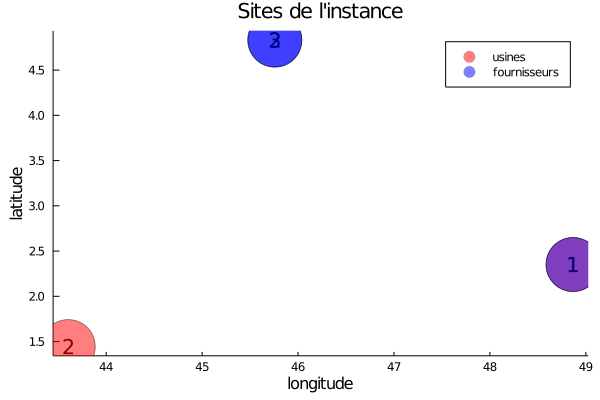

In [34]:
plot_sites(instance_petite)

### Route

In [35]:
function lire_route(row::String)::Route
    row_split = split(row, r"\s+")
    r = parse(Int, row_split[2]) + 1
    j = parse(Int, row_split[4]) + 1
    x = parse(Int, row_split[6])
    u = parse(Int, row_split[8]) + 1
    F = parse(Int, row_split[10])
    
    stops = RouteStop[]

    k = 11
    while k <= length(row_split)
        f = parse(Int, row_split[k+1]) + 1
        k += 2
        
        Q = Int[]
        while (k <= length(row_split)) && (row_split[k] == "e")
            push!(Q, parse(Int, row_split[k+3]))
            k += 4
        end
        push!(stops, RouteStop(f=f, Q=Q))
    end
    
    return Route(r=r, j=j, x=x, u=u, F=F, stops=stops)
end

lire_route (generic function with 1 method)

In [36]:
routes_petite = [lire_route(sol_petite[1+r]) for r = 1:length(sol_petite)-1]

3-element Array{Route,1}:
 Route 1
   Jour 1
   Nb de camions 1
   Usine de départ 1
   Nb d'arrêts 1
   Stop 1
      Fournisseur 1
      Livraison [0, 2]
 Route 2
   Jour 2
   Nb de camions 1
   Usine de départ 1
   Nb d'arrêts 3
   Stop 1
      Fournisseur 1
      Livraison [1, 1]
   Stop 2
      Fournisseur 2
      Livraison [1, 1]
   Stop 3
      Fournisseur 3
      Livraison [1, 1]
 Route 3
   Jour 2
   Nb de camions 2
   Usine de départ 2
   Nb d'arrêts 2
   Stop 1
      Fournisseur 2
      Livraison [3, 1]
   Stop 2
      Fournisseur 3
      Livraison [0, 1]

### Solution

In [37]:
function lire_solution(path::String)
    sol = open(path) do file
        readlines(file)
    end
    
    R = parse(Int, split(sol[1], r"\s+")[2])
    routes = [lire_route(sol[1+r]) for r = 1:R]
    
    return Solution(R=R, routes=routes)
end

lire_solution (generic function with 1 method)

In [38]:
solution_petite = lire_solution(joinpath("..", "sujet", "petite.txt"))

Solution
   Nb de routes: 3

## Solution analysis

### Utilities

In [39]:
function nb_stops(route::Route)::Int
    return route.F
end

nb_stops (generic function with 1 method)

In [40]:
function nb_km(route::Route, instance::Instance)::Float64
    usines, fournisseurs = instance.usines, instance.fournisseurs
    path = [
        usines[route.u].v;
        [fournisseurs[stop.f].v for stop in route.stops]
    ]
    return sum(instance.graphe.d[s, t] for (s, t) in zip(path[1:end-1], path[2:end]))
end

nb_km (generic function with 1 method)

In [41]:
function pickup(route::Route, ; u::Int, e::Int, j::Int)::Int
    if (route.j == j) && (route.u == u)
        return sum(stop.Q[e] for stop in route.stops)
    else
        return 0
    end
end

pickup (generic function with 1 method)

In [42]:
function delivery(route::Route; f::Int, e::Int, j::Int)::Int
    if route.j == j
        d = 0
        for stop in route.stops
            if stop.f == f
                d += stop.Q[e]
            end
        end
        return d
    else
        return 0
    end
end

delivery (generic function with 1 method)

In [43]:
function compute_stocks(solution::Solution, instance::Instance)
    J, U, F, E = instance.J, instance.U, instance.F, instance.E
    
    # Constraints (10.a) and (10.b)
    
    z⁻ = zeros(Int, U, E, J)
    z⁺ = zeros(Int, F, E, J)
    
    for e = 1:E, j = 1:J
        for route in solution.routes
            for u = 1:U
                z⁻[u, e, j] += route.x * pickup(route, u=u, e=e, j=j)
            end
            for f = 1:F
                z⁺[f, e, j] += route.x * delivery(route, f=f, e=e, j=j)
            end
        end
    end
    
    # Constraints (1) and (5)
    
    b⁺ = collect(instance.usines[u].b⁺[e, j] for u = 1:U, e = 1:E, j = 1:J)
    b⁻ = collect(instance.fournisseurs[f].b⁻[e, j] for f = 1:F, e = 1:E, j = 1:J)
    
    su0 = collect(instance.usines[u].s0[e] for u = 1:U, e = 1:E)
    sf0 = collect(instance.fournisseurs[f].s0[e] for f = 1:F, e = 1:E)
    
    su = Array{Int, 3}(undef, U, E, J)
    sf = Array{Int, 3}(undef, F, E, J)
    
    for e = 1:E, j = 1:J
        for u = 1:U
            su[u, e, j] = (j==1 ? su0[u, e] : su[u, e, j-1]) + b⁺[u, e, j] - z⁻[u, e, j]
        end
        for f = 1:F
            sf[f, e, j] = max(0, (j==1 ? sf0[f, e] : sf[f, e, j-1]) - b⁻[f, e, j]) + z⁺[f, e, j]
        end
    end
    
    return su, sf
end

compute_stocks (generic function with 1 method)

### Plotting

Routes

In [44]:
function add_route_to_plot!(route::Route, instance::Instance, pl::Plots.Plot)
    usines, fournisseurs = instance.usines, instance.fournisseurs
    path = [
        usines[route.u].coor;
        [fournisseurs[stop.f].coor for stop in route.stops]
    ]
    for ((x1, y1), (x2, y2)) in zip(path[1:end-1], path[2:end])
        plot!(
            pl,
            [x1 + 0.1*(x2-x1), x2 - 0.1*(x2-x1)],
            [y1 + 0.1*(y2-y1), y2 - 0.1*(y2-y1)],
            linewidth = 3*route.x,
            linecolor = "black",
            arrow = arrow(:simple, :triangle, 1., 2.),
            label = nothing
        )
    end
end

add_route_to_plot! (generic function with 1 method)

In [45]:
function plot_routes(solution::Solution, instance::Instance; j::Int)::Plots.Plot
    pl = plot_sites(instance)
    for route in solution.routes
        if route.j == j
            add_route_to_plot!(route, instance, pl)
        end
    end
    plot!(title="Routes de la solution à j=$j")
    return pl
end

plot_routes (generic function with 1 method)

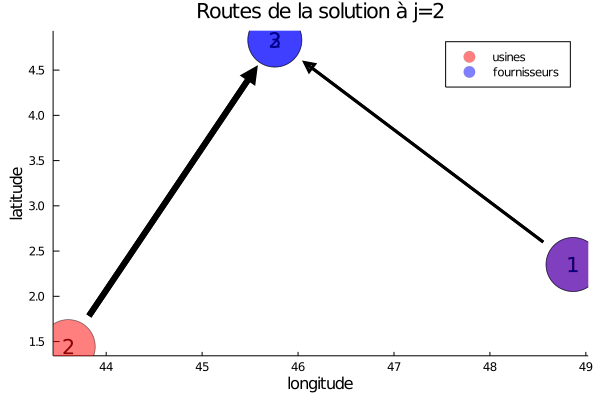

In [46]:
plot_routes(solution_petite, instance_petite, j=2)

Stocks

In [47]:
function plot_stocks(solution::Solution, instance::Instance, usine::Usine)::Plots.Plot
    su, _ = compute_stocks(solution, instance)

    _, E, J = size(su)
    pl = plot()
    for e = 1:E
        plot!(
            pl,
            1:J,
            su[usine.u, e, :],
            label="e=$e",
            lw=3,
            markershape=:circle
        )
    end
    plot!(
        pl,
        title="Stocks de l'usine $(usine.u)",
        ylabel="stock s[e, j]",
        xlabel="jour j",
        xticks=1:J,
        xlims=(0.5,J+0.5),
        ylims=(0, maximum(su[usine.u, :, :]) + 1)
    )
    return pl
end

plot_stocks (generic function with 1 method)

In [48]:
function plot_stocks(solution::Solution, instance::Instance, fournisseur::Fournisseur)::Plots.Plot
    _, sf = compute_stocks(solution, instance)

    _, E, J = size(sf)
    pl = plot()
    for e = 1:E
        plot!(
            pl,
            1:J,
            sf[fournisseur.f, e, :],
            label="e=$e",
            lw=3,
            markershape=:circle
        )
    end
    plot!(
        pl,
        title="Stocks du fournisseur $(fournisseur.f)",
        ylabel="stock s[e, j]",
        xlabel="jour j",
        xticks=1:J,
        xlims=(0.5,J+0.5),
        ylims=(0, maximum(sf[fournisseur.f, :, :]) + 1)
    )
    return pl
end

plot_stocks (generic function with 2 methods)

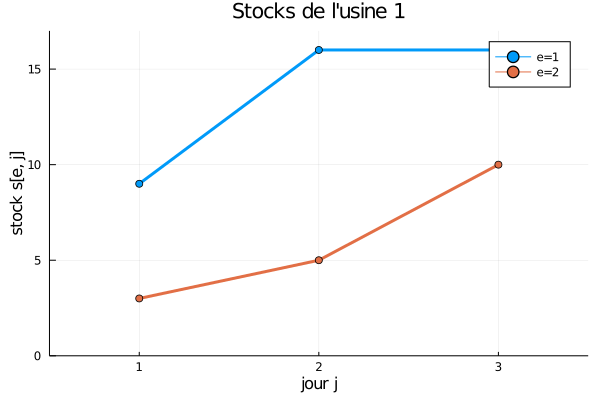

In [49]:
plot_stocks(solution_petite, instance_petite, usines_petite[1])

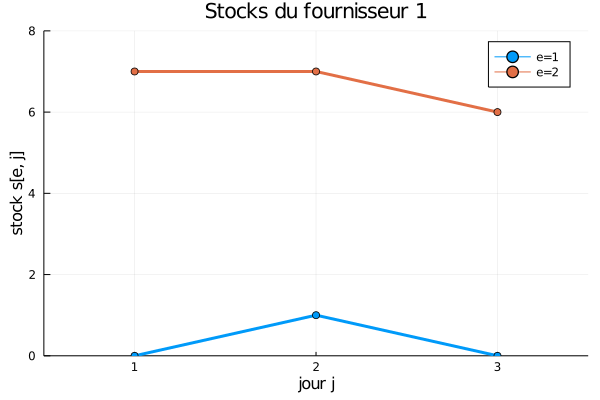

In [50]:
plot_stocks(solution_petite, instance_petite, fournisseurs_petite[1])

### Feasibility

In [51]:
function check_length(route::Route)::Bool
    @assert nb_stops(route) <= 4
    return true
end

check_length (generic function with 1 method)

In [52]:
function check_load(route::Route, instance::Instance)::Bool
    q = sum(stop.Q for stop in route.stops)
    l_route = sum(q[e] * instance.emballages[e].l for e = 1:instance.E)
     
    # Constraint (8)
    @assert l_route <= instance.L
    
    return true
end

check_load (generic function with 1 method)

In [53]:
function check_stock(usine::Usine, s::Matrix{Int})::Bool
    # Constraint (2)
    @assert all(0 .<= s)
    return true
end

check_stock (generic function with 1 method)

In [54]:
function check_stock(fournisseur::Fournisseur, s::Matrix{Int})::Bool
    # Constraint (4b)
    @assert all(0 .<= s)
    return true
end

check_stock (generic function with 2 methods)

In [55]:
function feasibility(solution::Solution, instance::Instance)::Bool
    J, U, F, E = instance.J, instance.U, instance.F, instance.E
    
    for route in solution.routes
        check_length(route)
        check_load(route, instance)
    end
    
    su, sf = compute_stocks(solution, instance)
    
    for usine in instance.usines
        check_stock(usine, su[usine.u, :, :])
    end
    for fournisseur in instance.fournisseurs
        check_stock(fournisseur, sf[fournisseur.f, :, :])
    end
    
    return true
end

feasibility (generic function with 1 method)

In [56]:
feasibility(solution_petite, instance_petite)

true

### Cost

#### Route

In [57]:
function truck_cost(route::Route, instance::Instance)::Float64
    return instance.ccam
end

truck_cost (generic function with 1 method)

In [58]:
function stops_cost(route::Route, instance::Instance)::Float64
    return instance.cstop * nb_stops(route)
end

stops_cost (generic function with 1 method)

In [59]:
function km_cost(route::Route, instance::Instance)::Float64
    return instance.γ * nb_km(route, instance)
end

km_cost (generic function with 1 method)

In [60]:
function cost_single_truck(route::Route, instance::Instance)::Float64
    return truck_cost(route, instance) + stops_cost(route, instance) + km_cost(route, instance)
end

cost_single_truck (generic function with 1 method)

In [61]:
function cost(route::Route, instance::Instance)::Float64
    return route.x * cost_single_truck(route, instance)
end

cost (generic function with 1 method)

#### Usine

In [62]:
function stock_cost(usine::Usine, s::Matrix{Int}; j::Int)::Float64
    E, J = size(s)
    return sum(usine.cs[e] * max(0., s[e, j] - usine.r[e, j]) for e = 1:E)
end

stock_cost (generic function with 1 method)

In [63]:
function cost(usine::Usine, s::Matrix{Int}; j::Int)::Float64
    return stock_cost(usine, s, j=j)
end

cost (generic function with 2 methods)

In [64]:
function cost(usine::Usine, s::Matrix{Int})::Float64
    E, J = size(s)
    return sum(cost(usine, s, j=j) for j = 1:J)
end

cost (generic function with 2 methods)

#### Fournisseur

In [65]:
function stock_cost(fournisseur::Fournisseur, s::Matrix{Int}; j::Int)::Float64
    E, J = size(s)
    c = sum(fournisseur.cs[e] * max(0., s[e, j] - fournisseur.r[e, j]) for e = 1:E)
    return c
end

stock_cost (generic function with 2 methods)

In [66]:
function expedition_cost(fournisseur::Fournisseur, s::Matrix{Int}; j::Int)::Float64
    E, J = size(s)
    c = sum(fournisseur.cexc[e] * max(0., fournisseur.b⁻[e, j] - (j == 1 ? fournisseur.s0[e] : s[e, j-1])) for e = 1:E)
    return c
end

expedition_cost (generic function with 1 method)

In [67]:
function cost(fournisseur::Fournisseur, s::Matrix{Int}; j::Int)::Float64
    return stock_cost(fournisseur, s, j=j) + expedition_cost(fournisseur, s, j=j)
end

cost (generic function with 3 methods)

In [68]:
function cost(fournisseur::Fournisseur, s::Matrix{Int})::Float64
    E, J = size(s)
    return sum(cost(fournisseur, s, j=j) for j=1:J)
end

cost (generic function with 3 methods)

#### Total

In [69]:
function cost_verbose(solution::Solution, instance::Instance)::Float64
    U, F, J = instance.U, instance.F, instance.J
    usines, fournisseurs = instance.usines, instance.fournisseurs

    su, sf = compute_stocks(solution, instance)

    c = 0.
    
    for u = 1:U
        println("Usine $u")
        for j = 1:J
            cujs = stock_cost(usines[u], su[u, :, :], j=j)
            c += cujs
            println("   Jour $j")
            println("      Coût stock: $cujs")
        end
    end
    cu = c
    
    println()

    for f = 1:F
        println("Fournisseur $f")
        for j = 1:J
            cfjs = stock_cost(fournisseurs[f], sf[f, :, :], j=j)
            cfje = expedition_cost(fournisseurs[f], sf[f, :, :], j=j)
            c += cfjs + cfje
            println("   Jour $j")
            println("      Coût stock: $cfjs")
            println("      Coût expédition: $cfje")
            println("      Coût total: " * string(cfjs + cfje))
        end
    end
    cf = c - cu
    
    println()
    
    for route in solution.routes
        println("Route $(route.r), jour $(route.j)")
        crt = truck_cost(route, instance)
        crs = stops_cost(route, instance)
        crk = km_cost(route, instance)
        rx = route.x
        c += route.x * (crt + crs + crk)
        println("   Coût camion: $crt")
        println("   Coût arrêts: $crs")
        println("   Coût kilométrique: $crk")
        println("   Nb camions: $rx")
        println("   Coût total: " * string(route.x * (crt + crs + crk)))
    end
    cr = c- cf - cu
    
    println()
    println("Coût total usines: $cu")
    println("Coût total fournisseurs: $cf")
    println("Coût total routes: $cr")
    println()
    println("Coût total: $c")

    return c
end

cost_verbose (generic function with 1 method)

In [70]:
function cost(solution::Solution, instance::Instance; verbose::Bool=false)::Float64
    if verbose
        return cost_verbose(solution, instance)
    end

    U, F, J = instance.U, instance.F, instance.J
    usines, fournisseurs = instance.usines, instance.fournisseurs

    su, sf = compute_stocks(solution, instance)
    
    c = 0.
    
    for u = 1:U
        c += cost(usines[u], su[u, :, :])
    end
    
    for f = 1:F
        c += cost(fournisseurs[f], sf[f, :, :])
    end
    
    for route in solution.routes
        c += cost(route, instance)
    end

    return c
    
end

cost (generic function with 4 methods)

In [71]:
cost(solution_petite, instance_petite)

884.0

In [72]:
cost(solution_petite, instance_petite, verbose=true)

Usine 1
   Jour 1
      Coût stock: 8.0
   Jour 2
      Coût stock: 22.0
   Jour 3
      Coût stock: 42.0
Usine 2
   Jour 1
      Coût stock: 16.0
   Jour 2
      Coût stock: 12.0
   Jour 3
      Coût stock: 24.0

Fournisseur 1
   Jour 1
      Coût stock: 8.0
      Coût expédition: 0.0
      Coût total: 8.0
   Jour 2
      Coût stock: 8.0
      Coût expédition: 110.0
      Coût total: 118.0
   Jour 3
      Coût stock: 4.0
      Coût expédition: 55.0
      Coût total: 59.0
Fournisseur 2
   Jour 1
      Coût stock: 0.0
      Coût expédition: 0.0
      Coût total: 0.0
   Jour 2
      Coût stock: 10.0
      Coût expédition: 0.0
      Coût total: 10.0
   Jour 3
      Coût stock: 16.0
      Coût expédition: 0.0
      Coût total: 16.0
Fournisseur 3
   Jour 1
      Coût stock: 0.0
      Coût expédition: 0.0
      Coût total: 0.0
   Jour 2
      Coût stock: 8.0
      Coût expédition: 0.0
      Coût total: 8.0
   Jour 3
      Coût stock: 8.0
      Coût expédition: 35.0
      Coût total: 43.0

Ro

884.0

## Writing files

In [73]:
function Base.string(stop::RouteStop)::String
    f = stop.f
    str = "f $(f-1)"
    E = length(stop.Q)
    for e = 1:E
        q = stop.Q[e]
        str *= " e $(e-1) q $q" 
    end
    return str
end

In [74]:
function Base.string(route::Route)::String
    r = route.r
    j = route.j
    x = route.x
    u = route.u
    F = route.F
    str = "r $(r-1) j $(j-1) x $x u $(u-1) F $F"
    for stop in route.stops
        str *= " " * string(stop)
    end
    return str
end

In [75]:
function Base.string(solution::Solution)::String
    R = solution.R
    str = "R $R"
    for route in solution.routes
        str *= "\n" * string(route)
    end
    return str
end

In [76]:
function write_sol_to_file(solution::Solution, path::String)::Bool
    open(path, "w") do file
        write(file, string(solution))
    end
    return true
end

write_sol_to_file (generic function with 1 method)

In [77]:
write_sol_to_file(solution_petite, joinpath("..", "sujet", "petite_copy.txt"))

true